# EP #2 - Harris Corner Detector

Renato Sérgio Lopes Júnior \
2020667570


In [1]:
import cv2
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Image Generation

In [2]:
def generate_img():
    img = np.zeros((200, 200, 1), np.uint8)
    for i in range(4):
        for j in range(i%2, 4, 2):
            img[i*50:(i+1)*50, j*50:(j+1)*50] = [255]
    cv2.imwrite('img.png', img)
    return img

def add_gaussian_noise(img, noise_level):
    noise = cv2.randn(img.copy(), (0), (255*noise_level))
    return cv2.add(img, noise)

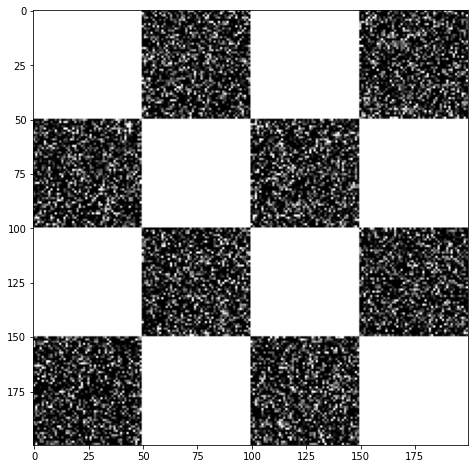

In [3]:
img = generate_img()
noise = 0.5
img_noisy = add_gaussian_noise(img, noise)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_noisy, cv2.COLOR_BGR2RGB))
plt.show()

## Harris Corner Detector

In [4]:
def get_gradients(img, window_size):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=window_size, borderType=cv2.BORDER_REFLECT)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=window_size, borderType=cv2.BORDER_REFLECT)
    return gx, gy

def create_c_matrix(gx, gy, i, j, window_size):
    C = np.zeros((2, 2))
    # Sum over the neighbourhood
    for k in range(i-int((window_size-1)/2), i+int((window_size-1)/2)+1):
        for l in range(j-int((window_size-1)/2), j+int((window_size-1)/2)+1):
            C[0][0] += gx[k][l]**2
            C[0][1] += gx[k][l]*gy[k][l]
            C[1][0] += gx[k][l]*gy[k][l]
            C[1][1] += gy[k][l]**2
    return C

def check_if_neighbour(corners, i, j, window_size):
    nb_limit = int((window_size-1)/2)
    for corner in corners:
        if corner[0] >= (i-nb_limit) and corner[0] <= (i+nb_limit) and corner[1] >= (j-nb_limit) and corner[1] <= (j+nb_limit):
            return True
    return False

def nms(corners, window_size):
    corners = sorted(corners, key=lambda x: x[0], reverse=True)
    corners_filtered = []
    for corner in corners:
        if not check_if_neighbour(corners_filtered, corner[1], corner[2], window_size):
            corners_filtered.append((corner[1], corner[2]))
    return corners_filtered

def harris(img, threshold, window_size):
    # Add padding to image
    img_pad = cv2.copyMakeBorder(img, window_size-1, window_size-1, window_size-1, window_size-1, cv2.BORDER_REFLECT)
    # Compute gradients
    gx, gy = get_gradients(img_pad, window_size)
    # Find corners
    corners = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            C = create_c_matrix(gx, gy, i, j, window_size)
            U, S, Vt = np.linalg.svd(C, full_matrices=False)
            lambda_2 = S[1]
            if lambda_2 > threshold:
                corners.append((lambda_2, i, j))
    # Remove corners whose neighbourhood overlap
    corners = nms(corners, window_size)
    return corners

In [5]:
corners = harris(img, 100, 3)

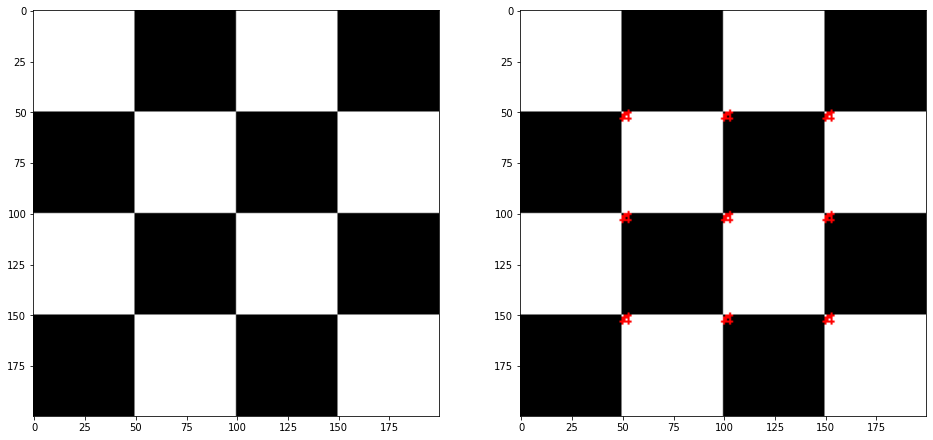

In [6]:
def draw_corners(img, corners):
    img = img.copy()
    for corner in corners:
        cv2.circle(img, corner, 1, (0,0,255), -1)
    return img

img_drawn = draw_corners(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), corners)

fig = plt.figure(figsize=(16, 32))
fig.add_subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_drawn, cv2.COLOR_BGR2RGB))
plt.show()